In [1]:
import matplotlib.dates as mdates

import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt

import ray

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess
from multi_run_v3.momentum import make_group_mask
from multi_run_v3.momentum_strategy import *
from multi_run_v2.initialize_v2 import make_market_index
#from multi_run_v3.backtest import simulate_longonly, simulate_longshort

2023-08-19 09:33:20,389	INFO worker.py:1625 -- Started a local Ray instance.


In [2]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [3]:
data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

In [4]:
mkt = make_market_index(data_pp.price_df,
                        data_pp.mktcap_df,
                        data_pp.vol_df,
                        1_000_000,
                        1_000_000,
                        True)

In [5]:
# Ray Data 생성
ray_price = ray.put(data_pp.price_df)
ray_mktcap = ray.put(data_pp.mktcap_df)
ray_vol = ray.put(data_pp.vol_df)
ray_daily_rtn = ray.put(data_pp.daily_rtn_df)
ray_weekly_rtn = ray.put(data_pp.weekly_rtn_df)
ray_mask = ray.put(data_pp.mask)

In [6]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

### Value Weighted, Marketcap Capped 

In [6]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       #num_cap=0.95, # 5% capped
                                                                       margin ='cross',
                                                                       leverage_ratio=2) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [7]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [8]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [50]:
pf_rtn = momentum_result_dict_c['FRI']['Long_Q1'].pct_change().fillna(0)
#pf_rtn = pf_rtn.replace(0, np.nan).dropna()
pf_rtn

2017-12-02    0.000000
2017-12-03    0.080013
2017-12-04    0.015994
2017-12-05   -0.048551
2017-12-06   -0.055561
                ...   
2023-04-12    0.004805
2023-04-13    0.025051
2023-04-14    0.006194
2023-04-15   -0.001521
2023-04-16    0.005060
Length: 1962, dtype: float64

In [51]:
mkt_weekly = (mkt + 1).cumprod().resample('W-FRI').last().pct_change().loc['2017-12-03':].iloc[:-1]
pf_weekly = momentum_result_dict_c['FRI']['Long_Q1'].pct_change(7).resample('W-FRI').last().dropna().iloc[:-1]

concat_df = pd.concat([mkt_weekly, pf_weekly],
          axis=1,
          keys=['mkt', 'pf'])
concat_df

,mkt,pf
2017-12-08,0.352870,NaN
2017-12-15,0.208649,0.335993
2017-12-22,-0.034090,0.085873
2017-12-29,0.165575,0.053881
2018-01-05,0.261609,0.169699
...,...,...
2023-03-17,0.282952,0.370077
2023-03-24,-0.016045,0.054354
2023-03-31,0.037816,0.034032
2023-04-07,-0.011019,-0.098459


In [52]:
when_bull = []
when_bear = []

for i in range(len(concat_df)-1):
    if concat_df.iloc[i].mkt > 0:
        dt = concat_df.index[i+1]
        when_bull.append(dt)
    
    else:
        dt = concat_df.index[i+1]        
        when_bear.append(dt)

In [53]:
# 밥먹고 할일 Forward Bias 있는지 살피고, 있으면 코드 수정 
len(when_bull), len(when_bear)

(150, 129)

<AxesSubplot:>

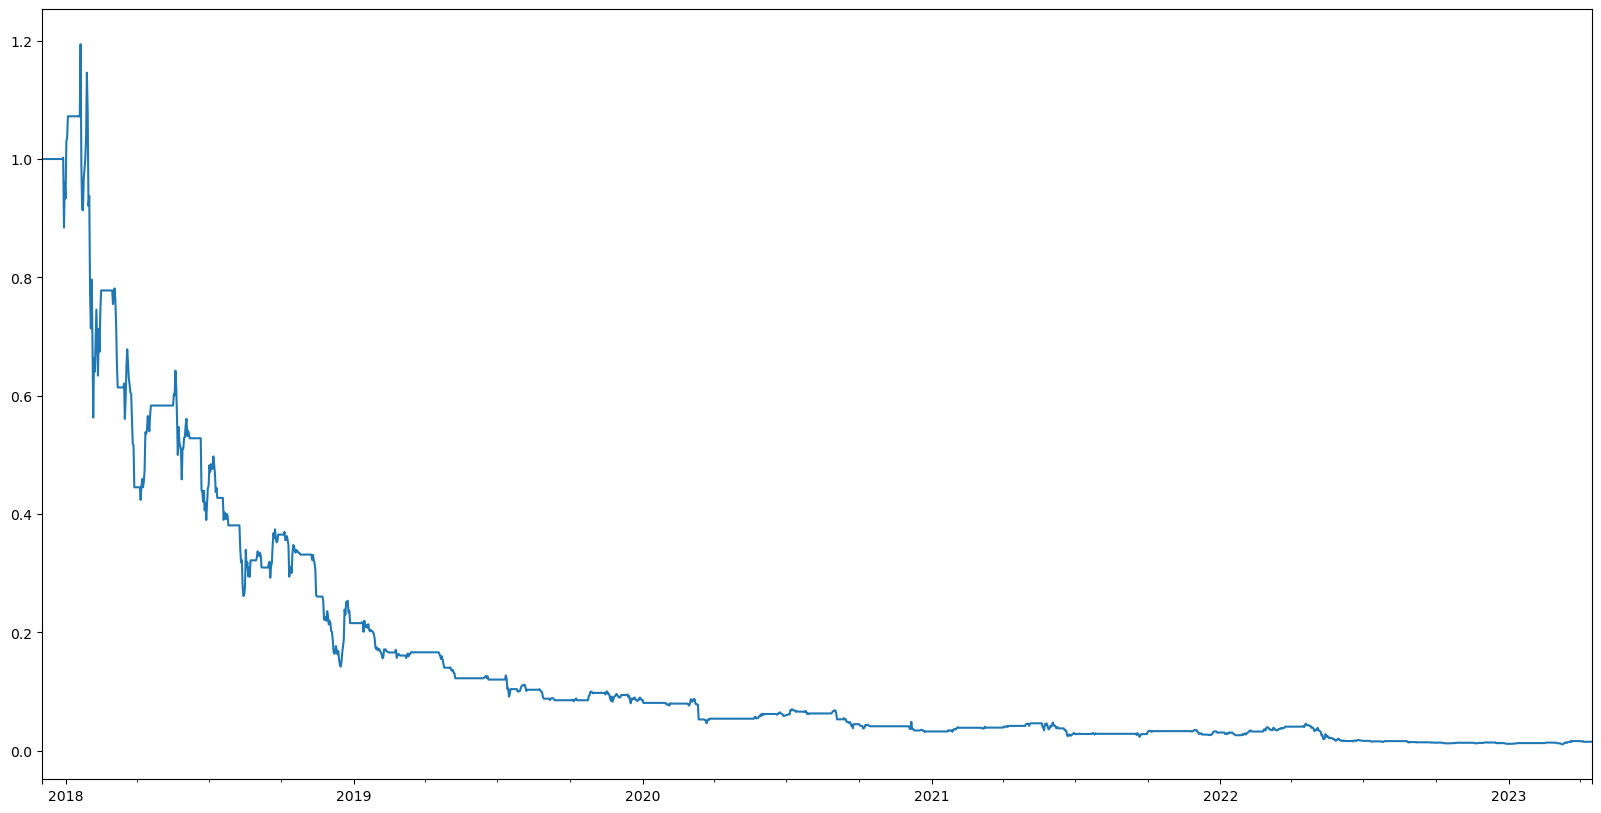

In [54]:
flag = False
cnt = 0
bear_re = pf_rtn.loc[when_bear].reindex(pf_rtn.index)

for date, rtn in bear_re.items():
    if str(date)[:10] in [str(i)[:10] for i in when_bear]:
        flag = True
        cnt = 2
    
    if (flag == True) and cnt > 1:
        bear_re.loc[date] = pf_rtn.loc[date]
        cnt += 1
    
    if cnt == 9:
        flag = False
        cnt = 0
        
(bear_re.fillna(0) + 1).cumprod().plot(figsize=(20,10))

<AxesSubplot:>

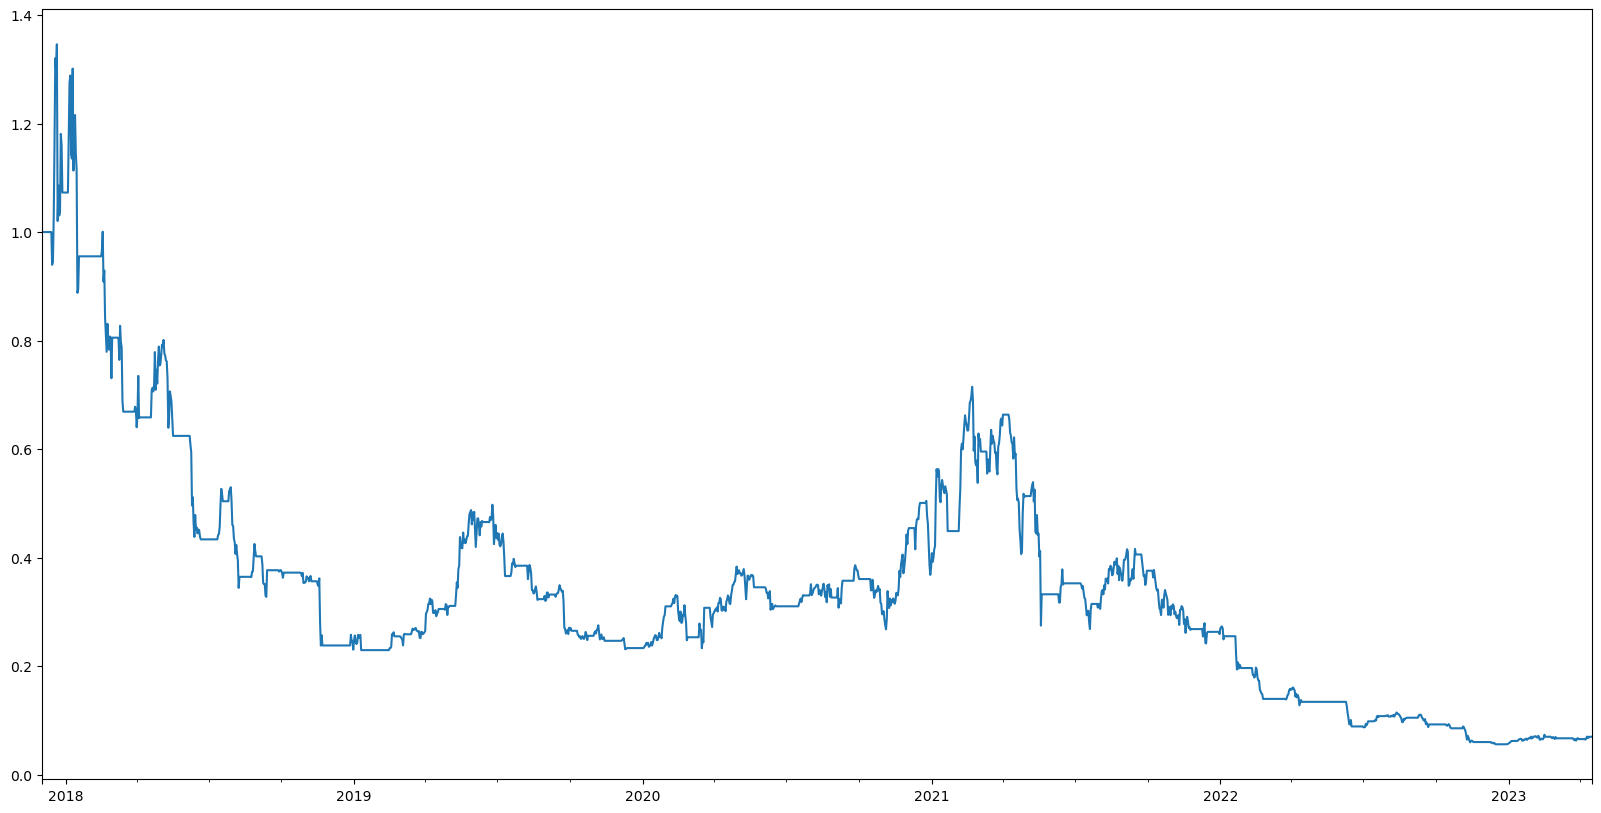

In [55]:
flag = False
cnt = 0
bull_re = pf_rtn.loc[when_bull].reindex(pf_rtn.index)

for date, rtn in bull_re.items():
    if str(date)[:10] in [str(i)[:10] for i in when_bull]:
        flag = True
        cnt = 2
    
    if (flag == True) and cnt > 1:
        bull_re.loc[date] = pf_rtn.loc[date]
        cnt += 1
    
    if cnt == 9:
        flag = False
        cnt = 0
        
(bull_re.fillna(0) + 1).cumprod().plot(figsize=(20,10))